In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import UsefulFunctions as uf
from obspy import UTCDateTime
from obspy import Trace
from obspy import Stream
from obspy.clients.fdsn import Client
from obspy.core.inventory.inventory import Inventory

In [2]:
# Earthquake variables
eq = uf.Earthquake(f'{uf.DATA_PATH}/AncScenarioGrids/Anc2018.xml')
eq_lat = eq.event['lat']
eq_lon = eq.event['lon']
eq_dep = eq.event['depth']


Start of Parsing for /home/afozkos/PycharmProjects/ShakeMapsProcessor/Data/AncScenarioGrids/Anc2018.xml
   ~~Detection stats~~
    Used a maximum azimuthal gap of 300 degrees and minimum station vector angle of 30 km
    Number of stations needed: 4
    Detection Time: 10.388833482841601
    Azimuthal Gap: 130.1260301467318
    Max Vector Angle: 80.80712944778097
    Maximum Epicentral Distance: 51.61387106500268
Finished parsing grid.xml for: M7.1, 1 km SE of Point MacKenzie, Alaska, at 2018-11-30T17:29:29 (ID:ak018fcnsk91)


In [11]:
vrup = 6.7 * 0.6 * 0.7
vsurf = 6.7 * 0.6 * 0.9
rup_dur = 12  # s


# ObsPY variables
client_wm = Client("IRIS")
of = 'Plots/test.png'
station_names = ['K223']
station_data = {}
st = Stream()
inv = Inventory()
# Define channel, network, origin time, and time range for waveforms
chan = 'HN?'
net = 'AK'
or_time = '2018-11-30T17:29:29.000Z'
or_time = UTCDateTime(or_time)
starttime = or_time
endtime = or_time + 40

# Loop over each station we want information from/for
for name in station_names:

    # Attempt to get waveform data
    try:
        st_cur = client_wm.get_waveforms(net, name, "*", chan, starttime, endtime)
        inv_cur = client_wm.get_stations(network=net, station=name, location="*", channel=chan, starttime=starttime,
                                         endtime=endtime, level='response')
        st += st_cur
        inv += inv_cur
    except:
        print(f'Error getting data from {name}')
        continue

    # Get location of current station
    lat = inv_cur[0][0].latitude
    lon = inv_cur[0][0].longitude
    # Find closest grid point in ShakeMap grid and pga
    subtracted_list = np.hstack((eq.lats - lat, eq.lons - lon))
    nearest_index = np.nanargmin(np.sum(subtracted_list**2, axis=1))
    pga = eq.pga[nearest_index, 0]
    # Calculate epicentral and hypocentral distance, and first-arrival times
    epi_dist = uf.getDistance(eq_lat, eq_lon, lat, lon)
    hypo_dist = (epi_dist**2 + eq_dep**2)**.5
    p_arr = hypo_dist/eq.vel_p
    s_arr = hypo_dist/eq.vel_s
    surf_arr = hypo_dist/eq.vel_surf
    peak_end = surf_arr + rup_dur
    # Save the info into the data dict
    station_data[name] = {'lat': lat,
                          'lon': lon,
                          'epi_dist': epi_dist,
                          'hypo_dist': hypo_dist,
                          'pga': pga,
                          'p_arr': p_arr,
                          's_arr': s_arr,
                          'surf_arr': surf_arr,
                          'peak_end': peak_end}


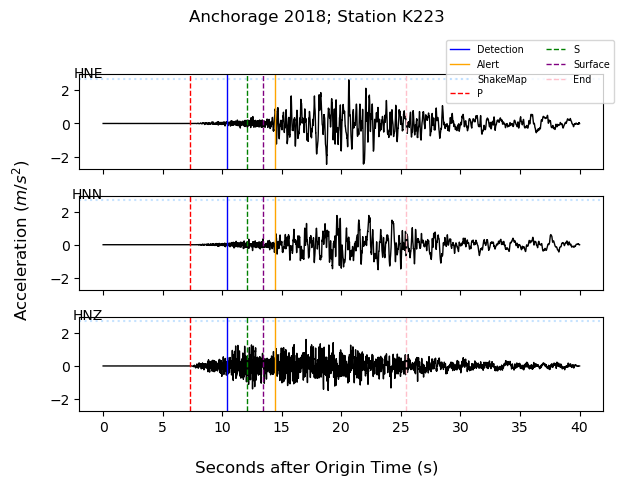

In [12]:
# remove instrument response and convert counts to Acceleration
resp_removed = st.copy()
resp_removed.attach_response(inv)
resp_removed = resp_removed.remove_response(output='ACC')

# Plot
t = resp_removed[0].times()
n_names = len(station_data.keys())
fig, ax = plt.subplots(n_names*3, 1, sharex='col', sharey='col')
fig.supylabel(r'Acceleration ($m/{s^2}$)')
fig.supxlabel('Seconds after Origin Time (s)')
fig.suptitle('Anchorage 2018; Station K223')
for i in range(len(resp_removed)):
    ax[i].text(0, station_data['K223']['pga']/100*9.8 - .1, resp_removed[i].stats.channel, ha='right', va='bottom')
    ax[i].plot(t, resp_removed[i].data, c='k', lw=1)
    ax[i].axvline(eq.detection_time, c='b', lw=1, label='Detection')
    ax[i].axvline(eq.alert_time, c='orange', lw=1, label='Alert')
    ax[i].axhline(station_data['K223']['pga']/100*9.8, c='dodgerblue', ls=':', alpha=.25, label='ShakeMap')

    ax[i].axvline(station_data['K223']['p_arr'], c='red', ls='--', lw=1, label='P')
    ax[i].axvline(station_data['K223']['s_arr'], c='green', ls='--', lw=1, label='S')
    ax[i].axvline(station_data['K223']['surf_arr'], c='purple', ls='--', lw=1, label='Surface')
    ax[i].axvline(station_data['K223']['peak_end'], c='pink', ls='--', lw=1, label='End')


ax[0].legend(loc=(0.7, 0.7), fontsize='x-small', ncol=2)
plt.tight_layout()
plt.savefig(of, dpi=720)


In [5]:
len(resp_removed)

3